
### Step 1: Import necessary modules and write main functions


In [1]:
import os
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import glob
import pickle
import re
from PIL import Image as IMG
tik1=time.time()


from datetime import datetime
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input


from tensorflow.keras.layers import Input
from keras.applications.vgg19 import preprocess_input as process_vgg19
from keras.applications.xception import preprocess_input as process_xception
from keras.applications.vgg16 import preprocess_input as process_vgg16
from keras.applications.densenet import preprocess_input as process_DenseNet








from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
Image.MAX_IMAGE_PIXELS = None


def fpmls_to_feature_filename(frame,projection,model_name,layer_name,sink,rv=False):
    if rv==False:
        answer='/data/scratch/rami/features/Sink_'+sink+'/'+model_name+'/'+layer_name+'/'+\
                'feature_frame_'+frame+'/projection_'+projection+'.pkl'
    elif rv==True:
        answer='/data/scratch/rami/features/Sink_'+sink+'/'+model_name+'/'+layer_name+'/'+\
                'feature_frame_'+frame+'/projection_'+projection+'_rv.pkl'
    return answer          
ans1=(fpmls_to_feature_filename('000100','3','666','vgg20','fc12'))


def fps_to_image_filename(frame,projection,sink,rv=False):
    if rv==False:
        answer='/data/scratch/rami/images/rescaled_Sink_'+sink+'/movie_frame_'+frame+'/projection_'+projection+'.pkl'
    elif rv==True:
        answer='/data/scratch/rami/images/rescaled_Sink_'+sink+'/movie_frame_'+frame+'/projection_'+projection+'_rv.pkl'
    return answer   

def feature_filename_to_fpmls(feature_filename):
    num = re.findall(r'\d+', feature_filename)
    sink=num[0]
    model_number=num[1]
    layer_number=num[2]
    frame=num[3]
    projection=num[4]    
    if model_number=='16':
        model_name='vgg16'
    elif model_number=='19':
        model_name='vgg19'
    else:
        print('incorrect model number extraction from filename')
        
    if layer_number=='1':
        layer_name='fc1'
    elif layer_number=='2':
        layer_name='fc2'
    elif layer_number=='4':
        layer_name='block4_pool'
    elif layer_number=='5':
        layer_name='block5_pool'
    else:
        print('incorrect layer number extraction from filename')
              
#     print(num)
#     print('frame,projection,model,layer,sink=%s,%s,%s,%s,%s'%(frame,projection,model_number,layer_number,sink))
    return frame,projection,model_name,layer_name,sink


def feature_filename_to_image_filename(feature_filename):
    if 'rv' in feature_filename:
        rv=True
    else:
        rv=False
    f,p,m,l,s=feature_filename_to_fpmls(feature_filename)
    ans=fps_to_image_filename(frame=f,projection=p,sink=s,rv=rv)
    return ans


def image_filename_to_fps(image_filename):
    num = re.findall(r'\d+', image_filename)
    frame=num[-2]
    projection=num[-1]
    sink=num[0]   
    return frame,projection,sink



### Load the Neural Network from local files
def conv_model(model_name='resnet',show_model=False,use_timing=True, layer_name='flatten'):
    t_1=time.time()
    path='/data/scratch/rami/models/'+model_name+'/'+layer_name
    model = tensorflow.keras.models.load_model(path,compile=False)
    t_2=time.time()
    if model==None:
        print('Incorrect model_name fed to function conv_model')
    elif model!=None:
        for layer in model.layers:
            layer.trainable=False
    t_3=time.time()
    if show_model==True:
        model.summary()
    t_4=time.time()
    if use_timing:
        print('Loading convolutional model:',model_name)
        print('%1.2f sec to load the model parameters'%(t_2-t_1))
        print('%1.2f sec to freeze the model layers'%(t_3-t_2))
        print('%1.2f sec to show the model parameters'%(t_4-t_3))
        
    return model


# Load a file from inside a pickle 
def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file,encoding='bytes')
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    x = np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    
    return image_rgb,x




 # Delete the neural network 
def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()

def get_neighbors(feature_vector,feature_vectors, k=5,metric='euclidean'):
    '''Function that returns the neighbor distances and their indeces (of the image array corresponding to the images names)'''
    print('shape of 1) feature, 2) features :',np.shape(feature_vector),np.shape(feature_vectors))
    
    similar_idx=[]
    if metric=='braycurtis':
        similar_idx = [ distance.braycurtis(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='canberra':
        similar_idx = [ distance.canberra(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='euclidean':
        similar_idx = [ distance.euclidean(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='chebyshev':
        similar_idx = [ distance.chebyshev(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='cityblock':
        similar_idx = [ distance.cityblock(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='correlation':
        similar_idx = [ distance.correlation(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='cosine':
        similar_idx = [ distance.cosine(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='hamming':
        similar_idx = [ distance.hamming(feature_vector, feat) for feat in feature_vectors ]
    else:
        print('Invalid distance')
#     print('After calculating the distance we have:',similar_idx)
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:0+k]
    distances=[]
    for i in idx_closest:
        distances.append(similar_idx[i])
    distances=np.array(distances)
    idx_closest=np.array(idx_closest)
    return distances,idx_closest        




# Load an image to the neural network
def load_image(image_path,model,model_name='resnet'):
    '''Load an image an preprocess it, and return the image and the preprocessed input'''
#     print('Model input shape:',model.input_shape[1:3])
    img = image.load_img(image_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    ##xx
    else:
        print('Incorrect  model_name fed to function load_image')
    return img, np.array(x)

def load_pickle(file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    '''Loads a pickle file simply'''
    information=open(file,"rb")
    result=pickle.load(information,encoding='bytes')
    information.close()
    return result

def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file,encoding='bytes')
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    x = np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    
    return image_rgb,x


#Find the convolutional feature for an image
def img_to_conv_features(model,x):
    '''Convert 1 image to its convolutional features'''
   
    feat=model.predict(x)
    feature=feat.flatten()
    return np.array(feature)

# Find the convolutional features for a set of images
def imgs_to_conv_features(model,images,model_name):

    
    tic = time.process_time()
    every=20
    features = []
    for i, images_path in enumerate(images):

        img,x = load_image(image_path=images_path,model=model,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(images),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   

        
    print('finished extracting features for %d images' % len(images))
    return np.array(features)

def pickles_to_conv_features(pickles,model,model_name):
       
    tic = time.process_time()
    every=20
    features = []
    for i, pickle_file in enumerate(pickles):

        img,x = load_img_from_pickles(pickle_file=pickle_file,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(pickles),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   
        
    print('finished extracting features for %d images' % len(pickles))
    return np.array(features)


def choose_pickles_wildcards(max_num_pickles=200, pickles_path=''):
    files=[]
    i=1
    for file in glob.glob(pickles_path):
    #     print(name)
        files.append(file)
        if i>=max_num_pickles:
            break
        i+=1
    return files
# Find the paths of all images ina folder.
def choose_imgs(max_num_images=2000,images_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'):
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    print(np.shape(images))
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))
    return images


# Choose pickle files
def choose_pickles(max_num_pickles=2000,pickles_path='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    pickles_extensions = ['.pkl']   # case-insensitive (upper/lower doesn't matter)
    pickles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pickles_path) for f in filenames if os.path.splitext(f)[1].lower() in pickles_extensions]
    if max_num_pickles < len(pickles):
        pickles = [pickles[i] for i in sorted(random.sample(range(len(pickles)), max_num_pickles))]

#     print("keeping %d pickles." % len(pickles))
    return pickles

def get_scores(pickles_path):
    #This function gets the folder frame and gives back a 3xN array which contains the frame number, the projection number and zeros on the last matrix (for there we will save the score)
    pickles_extensions = ['.pkl']   # case-insensitive (upper/lower doesn't matter)
    pickles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pickles_path) for f in filenames if os.path.splitext(f)[1].lower() in pickles_extensions]
    if max_num_pickles < len(pickles):
        pickles = [pickles[i] for i in sorted(random.sample(range(len(pickles)), max_num_pickles))]
    filespace=np.zeros((3,len(pickles)))
    for i,pickle_ in enumerate(pickles):
        frame=pickle_[-23:-17]
        projection=pickle_[-5:-4]
        filespace[0,i]=frame
        filespace[1,i]=projection
    return filepsace

# Reduce dimensionality of data.
def reduce_PCA(features,n_components=40):
    features = np.array(features)
    pca = PCA(n_components=n_components)
    pca.fit(features)
    pca_features = pca.transform(features)
    return pca_features

# Plot the feature vector of a network
def plot_activation_layer(feature_vector):
    
    print(np.shape(feature_vector))
    feature_vector=np.array(feature_vector)
    feature_vector=feature_vector.flatten()
    plt.figure(figsize=(16,4))
    plt.ylabel('Activations of last layer (fc2)')
    plt.xlabel('## of neuron')
    plt.plot(feature_vector)
    plt.show()
    plt.close()
    
    return 0

def plot_img_from_pickles(pickle_file='',title=None, \
                          power=0.1):
    file = open(pickle_file, "rb")
    image = pickle.load(file,encoding="ASCII")
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    image_before_preprocess=np.expand_dims(image_rgb, axis=0)
    plt.figure(figsize=(10,10))
    if title!=None:
        plt.title(title)
    plt.imshow(image**power)
    return 0



# Plot best 5 matches function
def get_concatenated_images(indexes,images, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

tik2=time.time()

print('Cell run time=',(tik2-tik1))

2022-02-06 14:04:01.104667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Cell run time= 0.4237964153289795


### Step 2: Configure GPU devices and set a memory limit.

### Just plotting the images on their own cell

### 


synthetic observation: 2000 AU/ 800 pixels/ 0.4 pixels per AU


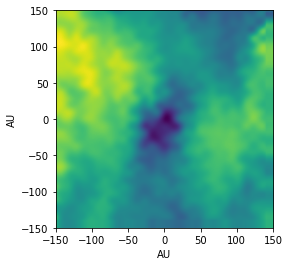

moment map: 230.19116883116882 AU/ 224 pixels/ 0.9731042295731611 pixel per au
num ~ 8


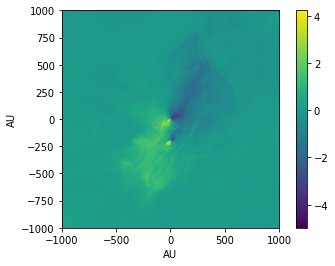

/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_1.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_2.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_3.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_4.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_5.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_6.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_7.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_8.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_9.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_10.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv_11.pkl
/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7

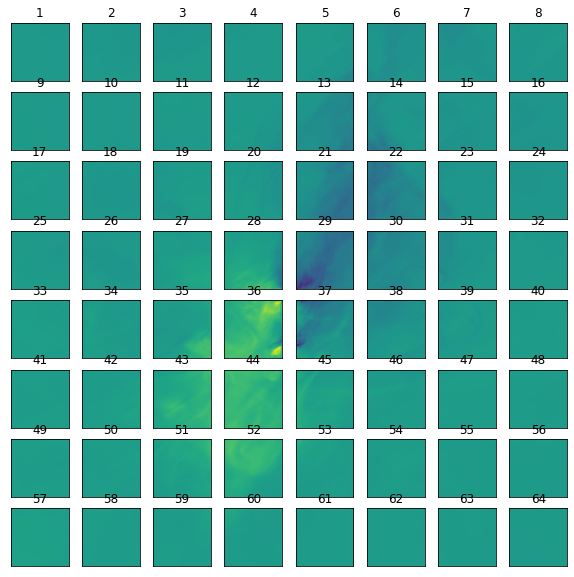

In [55]:

# Crop an image:
def crop_image(im,num,y,x):
    # Image size
    width, height =np.shape(im)
    
    # Setting crop boundaries in pixels
    left = width*x/num
    right = width*(x+1)/num
    top = height*y/num
    bottom =height*(y+1)/num

    # crop limits formatted as needed by im.crop
    limits=(left, top, right, bottom)
    limits=np.round(limits)
    im1 = im.crop(limits)
    
   
    return np.array(im1)

### This is a function that is given a synthetic observation with its field of view, the moment map with its field of view,
# and gives back many cropped images of the synthetic observation with the field view of the moment maps.
def jklmnop(synthetic_file,moment_file):
    
    # read and analyze the syntehtic file fov
    synthetic_observation=load_pickle(file=synthetic_file)
    ## a typical path looks like this :/data/scratch/rami/images/rescaled_Sink_91/movie_frame_000587/projection_6_rv.pkl
    
    #parameters of synthetic observation
    d_AU_syn=2000 # width of picture in AU
    d_pixels_syn=np.shape(synthetic_observation)[0] # width of picture in pixels
    pixel_per_AU_syn=d_pixels_syn/d_AU_syn #pixel per au on synthetic os
    print('synthetic observation:',d_AU_syn,'AU/',d_pixels_syn,'pixels/',pixel_per_AU_syn,'pixels per AU') #print
    
    # Read and analyze the moment map file
    moment_map=load_pickle(file=moment_file) #typical filename would be:
    
    extent=[-150,150,-150,150]
    plt.imshow(np.array(moment_map),extent=extent)
    
    plt.ylabel('AU')
    plt.xlabel('AU')
    plt.show()
    # a typical moment map looks like this:data/scratch/rami/images/Observation/mom1_7x_y_b_a_34_34_16_23.pkl
    
    
    # Hard stuff... We need to find the pixel per AU on zoomed in moment map. It's encoded in it's name:
    num = re.findall(r'\d+', moment_file)  
    n_mom=int(num[1])
    x_center=int(num[2])
    y_center=int(num[3])
#     box_size=int(num[4])
    box_size=30 #in pixels, minimum is 1. maximum is 77.
    angle=int(num[5])
    
    #Total width of moment map in AU
    d_AU_mom=147.706*2* (2*box_size/77)     #whole map is 147.706*2 AU. we would have this width if the box size was half the width (77pixels/2)
    # Therefore for an arbitary box_size b, the d_AU is: d_AU =b*147*2/(77/2)# as seen in moment maps
    d_pixels_mom=224    #preset neural network size input.
    pixel_per_AU_mom=d_pixels_mom/d_AU_mom
    print('moment map:',d_AU_mom,'AU/',d_pixels_mom,'pixels/',pixel_per_AU_mom,'pixel per au')
    num=int(d_AU_syn//d_AU_mom)
    print('num ~',num)
    
    
    im_syn=IMG.fromarray(synthetic_observation)
    vmin=np.amin(synthetic_observation)
    vmax=np.amax(synthetic_observation)
    extent=[-1000,1000,-1000,1000]
    
    plt.imshow(np.array(synthetic_observation),vmin=vmin,vmax=vmax,extent=extent)
    
    plt.ylabel('AU')
    plt.xlabel('AU')

    plt.colorbar();
    plt.show()
    # plt.close()

    fig = plt.figure(figsize=(10,10))

    # setting values to rows and column variables
    rows = num
    columns = num
    i=1

    imgs=[]
    names=[]
    for y in range(num):
        for x in range(num):
    #         print('(%d/%d, %d /%d)'%(x+1,num,y+1,num))
            fig.add_subplot(rows, columns,i)
            new_img=crop_image(im=im_syn,num=num,x=x,y=y)
            plt.imshow(new_img,vmin=vmin,vmax=vmax)
            plt.title(str(i))
#             plt.colorbar();
            imgs.append(new_img)
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            name=synthetic_file[:-4]+'_'+str(i)+synthetic_file[-4:]
            print(name)
            names.append(name)
            i+=1
    # plt.close()

    
    return imgs,names
pics,names=jklmnop(synthetic_file='/data/scratch/rami/images/rescaled_Sink_49/movie_frame_001518/projection_7_rv.pkl',\
            moment_file='/data/scratch/rami/images/Observation/mom1_7x_y_b_a_34_34_16_23.pkl')






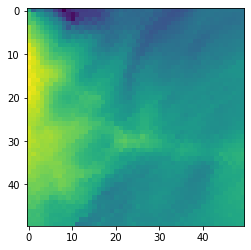

In [34]:
# print(len(pics))
plt.imshow(pics[136])
plt.show()
plt.close()


In [45]:
file_location='/data/scratch/rami/Moments/Reggie_troels_moments/B3.pkl'
X, Y, image, vel_rad, X_vel, Y_vel, velx, vely, part_info, args_dict, simfo, center_vel_rv = pickle.load(file_location)

TypeError: file must have 'read' and 'readline' attributes

In [ ]:


def augment_pictures(pictures_path='/data/scratch/rami/Im/Sink_49/vgg16/block4_pool/feature_frame_00????/projection_?.pkl',max_pictures=20,\
                 model_name='vgg16', layer_name='block4_pool',\
                 metric='euclidean',k=5,use_PCA=False,n_components=500,\
                 use_timing=False,display_output=True,\
                 save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/'):
    
    
    
    picture_files=choose_pickles_wildcards(max_num_pickles=max_num_pickles,pickles_path=pickles_path)
#     print("images shape:",np.shape(feature_files))
    if use_timing:
        t3 = time.time()
        
        
        
  # Create an array containing all features
    augmented_pictures=[]
    every=200
    for i, picture in enumerate(picture_files):
        if i==0:
            tic = time.process_time()
        
        
        im = Image.fromarray(img)
        
        # Size of the image in pixels (size of original image)
        # (This is not mandatory)

        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        frame,projection,sink=image_filename_to_fps(match)
        title='movie frame:%s \n projection %s \n sink %s \n'%(frame,projection,sink)+str(j)+' best match,\n distance=%1.3e'%distances[j-1]
        if display_output:
            plt.title(title)
#         print(np.shape(img))
        if display_output:
            if rv==True:
                ax.imshow(img)
            elif rv==False:
                ax.imshow(img**0.1)
#                 plt.imshow(img**0.1)
        j+=1

    if use_timing:
        t6 = time.time()    
        


    # Timing outputs
    ###########################################################################
    if use_timing:
        Dt1=t1-t0
        Dt2=t2-t1
        Dt3=t3-t2
        Dt4=t4-t3
        Dt5=t5-t4
        Dt6=t6-t5

        print('\n')
        print('\n')
        print('Dt1=%3.3f s:Model parameter loading: '%Dt1)

        print('Dt2=%3.3f s:1) Image preprocessing and 2)loading of feature calculator 3) feature calculation for one image'%Dt2)
        print('\n Of which: \n')
        print('%.2f s  for loading image'%(t11-t1))
        print('%.2f s  for calculating convolutional features'%(t13-t12))


        print('Dt3=%3.3f s:Choosing the images from the folder:'%Dt3)
        print('Dt4=%3.3f s:Images to convolutional features for %d images'%(Dt4,max_num_images))
        print('Dt5=%3.3f s:PCA '%Dt5)
        print('Dt6=%3.3f s:K nearest neighbohrs'%Dt6)
        print('\n')
        print('\n')
#     for i in range(np.shape(features)[0]):
#         if i%100==0:
#             if (features[0,:]==features[i,:]).all():
# #                 print('feature vectors 0 and %d are the same'%i)
    return names_output,np.array(distances_output)

tik2=time.time()

print('Cell run time=',(tik2-tik1))

In [ ]:
tik1=time.time()
best_matches1=Image_search_v2( pickle_path='/data/scratch/rami/features/Sink_49/vgg16/fc2/feature_frame_000521/projection_3.pkl',\
                     pickles_path='/data/scratch/rami/features/Sink_49/vgg16/fc2/feature_frame_00????/projection_?.pkl',\
                max_num_pickles=3072,\
                 model_name='vgg16', layer_name='fc2',\
                 metric='euclidean',k=20,use_PCA=False,n_components=500,\
                 use_timing=False,display_output=True,\
                 save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/')




tok=time.time()
print('time of execution',tok-tik1)

print(best_matches1)


In [ ]:
# #   data/scratch/rami/features/Sink_49/vgg19/fc1/feature_frame_000202/projection_5.pkl  


from matplotlib import collections  as mc



#get the scoreboard of distances between observation on pickle_path and simulations on pickles_path.

def get_score_board(images_path='/data/scratch/rami/images/rescaled_Sink_164/movie_frame_000084/projection_5_rv.pkl', \
                    sink_pickles='49',\
                    max_num_pickles=3072,k=3072,\
                    model_names=['vgg16'],layer_names=['fc2'],metrics=['euclidean'],\
                    display_histograms=True,save_histograms=True,rv=False):
    
   # Initialize matrixes names_board which contains all names upon the search is done
    if rv==False:
        images_path='/data/scratch/rami/images/rescaled_Sink_'+sink_pickles+'/movie_frame_00????/projection_?.pkl'
    elif rv==True:
        images_path='/data/scratch/rami/images/rescaled_Sink_'+sink_pickles+'/movie_frame_00????/projection_?_rv.pkl'
    names_board=choose_pickles_wildcards(max_num_pickles=max_num_pickles,pickles_path=images_path)
    names_board=np.array(names_board)
    #shape y expresses the number of distance measures, by combining 
    # neural network used,layer used, distance measure
    shape_y=np.shape(metrics)[0]*np.shape(layer_names)[0]*np.shape(model_names)[0]
    #initialize matrix score_board which will contain the distances of observation with pickles for 
    #all possible combinations of neural networks, layers and metrics.
    score_board=np.zeros(shape=(np.shape(names_board)[0],shape_y))


    i_=0
    if display_histograms==True:
    # Set plot dimensions and amount of subplots (histograms)
        plot_height=max(shape_y//4,1)
        plot_width=4
        fig,axs = plt.subplots(plot_height,plot_width,figsize=(20,int((30*shape_y)//20)))
    for model_name in model_names:
        for layer_name in layer_names:
            for metric in metrics:
                
                pickle_path='/data/scratch/rami/features/Observations/'+model_name+'/'+layer_name+'/moment_1.pkl'
                if rv==False:
                    pickles_path='/data/scratch/rami/features/Sink_'+sink_pickles+'/'+model_name+'/'+layer_name+'/'+'feature_frame_00????/projection_?.pkl'
                elif rv==True:
                    pickles_path='/data/scratch/rami/features/Sink_'+sink_pickles+'/'+model_name+'/'+layer_name+'/'+'feature_frame_00????/projection_?_rv.pkl'
                print('correct paths : ', pickle_path,'\n',pickles_path)
                #For a specific combination of neuralnet,layer,metric search through the names_board
                names,distances_before=Image_search_v2(pickle_path=pickle_path, \
                                                       pickles_path=pickles_path,\
                                                       max_num_pickles=max_num_pickles,\
                                                       model_name=model_name, layer_name=layer_name,\
                                                       metric=metric,k=k,use_PCA=False,n_components=500,\
                                                       use_timing=False,display_output=False,\
                                                       save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/')
                #best matches image filenames
                names=np.array(names)
                
                # normalization of distances in 0-1.
                distances=distances_before/np.amax(distances_before)
                distances=np.array(distances)
                print('top 10')
                print(names[:10])
                print(distances[:10])
#                 print('printing distances')
#                 for dist in distances:
#                     print('dist:',dist)
            
#                 print('shapes of names, distances, names_board,scoreboard:',np.shape(names),np.shape(distances),np.shape(names_board),np.shape(score_board))
                for _,name in enumerate(names):
#                     print(_,'name',name)
                    idx=np.where(names_board==name)
#                     print('names_board[idx]=',names_board[idx],'wow')
                    score_board[idx,i_]=distances[_]
                print(model_name,layer_name,metric)
                plots_num=shape_y
                if display_histograms==True:   
#                     print(np.shape(score_board))
                    best=5
#                     for ind in range(best):
#                         print('%d best: %s,\n \t  model=%s,\n \t  layer=%s\n \t  metric:%s\n \t  distance=%f'%(ind,names[ind],model_name,layer_name,metric,distances[ind]))
                    axs[i_//plot_width,i_%plot_width].hist(score_board[:,i_],bins=100,range=(0,1))
                    
                    print(i_//plot_width,i_%plot_width)
#                     axs[i_//plot_width,i_%plot_width].set_ylabel('## No of counts')
#                     axs[i_//plot_width,i_%plot_width].set_xlabel('Distance')
#                     axs[i_//plot_width,i_%plot_width].set_yscale('log')
                    title=metric+':'+model_name+':'+layer_name
                    axs[i_//plot_width,i_%plot_width].set_title(title)
                
                
                i_+=1
    if save_histograms==True:
        fig.savefig("histograms.jpeg")
    fig.tight_layout()
    plt.show()
    
    return score_board,names_board

    

In [ ]:
# # frame='155'
# # projection='4'
# max_num_pickles=300000
# # k=max_num_pickles
# # model_names=['vgg16','vgg19']
# # layer_names=['fc1','fc2','block5_pool','predictions','block4_pool']
# # metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']
# # score,names=get_score_board(frame=frame,projection=projection,max_num_pickles=k,k=k,\
# #                     model_names=model_names,layer_names=layer_names,metrics=metrics)
# k=3361
# sink_pickle='49'
# frame='000521'
# projection='3'

# sink_pickles='164'
# model_names=['vgg16','vgg19']
# layer_names=['block5_pool','block4_pool','fc1','fc2']
# metrics=['euclidean']
# score,names=get_score_board(sink_pickle=sink_pickle,frame=frame,projection=projection,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
#                             model_names=model_names,layer_names=layer_names,metrics=metrics,\
#                     display_histograms=True,save_histograms=True)

# # model_names=['vgg16']
# # layer_names=['block5_pool']
# # metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']
# # score,names=get_score_board(frame=frame,projection=projection,max_num_pickles=k,k=k,\
# #                     model_names=model_names,layer_names=layer_names,metrics=metrics)

In [ ]:
# print(score[:10,:10])
# print(names[:10])

In [ ]:
def collapse_score_1D(names,score,k=None):
    if k==None:
        k=len(names)
    distances=[]

    for i in range(np.shape(score)[0]):
        dist=np.linalg.norm(score[i,:])
        distances.append(dist)
    distances=np.array(distances)
    names=np.array(names)

#     print(names[:1000])
#     print(distances[:1000])
    names_sorted = [x for _,x in sorted(zip(distances,names))]
    distances=sorted(distances)
#     print(names[:100])
    
#     print(distances[:100])
    similarities=[]
    print('distances shape,score 2 shape, k',np.shape(distances),np.shape(score)[1],k)
    for i in range(k):
        similarity=100*(1-distances[i]/np.sqrt(np.shape(score)[1]))
        similarities.append(similarity)
        print('%2.2f'%similarity,'% similarity with ',names_sorted[i])
    similarities=np.array(similarities)
    return names_sorted[:k],similarities[:k]
# names_sorted,similarities=collapse_score_1D(names,score,k=100)

In [ ]:
 #Plot the observation.
    #Optimally done if the amount of best matches inserted is a multiple of 4
def plot_best_matches(matches_names,observation,match_distances,save=True):
    
    frame_pickle,projection_pickle,sink_pickle=image_filename_to_fps(observation)
    
    title='movie frame:%s \n projection %s \n sink %s \n'%(frame_pickle,projection_pickle,sink_pickle)+'Observation'
    
    plot_img_from_pickles(pickle_file=observation,power=0.1,title=title)
    k=len(matches_names)
    plot_width=4
    plot_height=k//4

    fig = plt.figure(figsize=(20, int((30*k)//20)))
    #Plot and print the best matches
    j=1
    #loop over the best k matches
    for match in  matches_names:
        
        ax = fig.add_subplot(plot_height,plot_width,j)
        img=load_pickle(match)
        frame,projection,sink=image_filename_to_fps(match)
        title='movie frame:%s \n projection %s \n sink %s \n'%(frame,projection,sink)+str(j)+' Similarity: :%2.1f %%'%match_distances[j-1]
#         if display_output:
        plt.title(title)
#         print(np.shape(img))

        ax.imshow(img)
#                 plt.imshow(img**0.1)
        j+=1
    fig.tight_layout()
    if save:
        fig.savefig('best_matches.jpeg',dpi=100)
    plt.show()
    return 0
# plot_best_matches(names_sorted,'/data/scratch/rami/images/rescaled_Sink_49/movie_frame_000521/projection_3.pkl',similarities)

In [ ]:
# plot_img_from_pickles(pickle_file='/lustre/astro/rlk/Image_only_pickles/Sink_91_HR/movie_frame_000105/projection_2.pkl',title=None, power=0.1)

In [ ]:
# max_num_pickles=3361
# k=3361


# ######################################################################################################################

# # models to use                              
# model_names=['vgg16','vgg19']
# #layers from models to use
# layer_names=['block5_pool','block4_pool']
# #metrics to measure distance
# metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']
# # metrics=['euclidean']
# # Observation
# sink_pickle='164'
# frame='000468'
# projection='0'
# rv=False
# # Simulations
# sink_pickles='164'

# #####################################################################################################################
# # Calculate distances for all combinations of above parameters

# observation=fps_to_image_filename(frame=frame,projection=projection,sink=sink_pickle,rv=rv)
# score,names=get_score_board(sink_pickle=sink_pickle,frame=frame,projection=projection,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
#                             model_names=model_names,layer_names=layer_names,metrics=metrics,\
#                     display_histograms=True,save_histograms=True,rv=rv)

# # Reduce the information of distances on a single similarity index
# names_sorted,similarities=collapse_score_1D(names,score,k=24)

# l=len(names)
# #Display best matches
# plot_best_matches(names_sorted[:24],observation,similarities[:24])

In [ ]:
#max number of images to analyze
max_num_pickles=5000
# length of scoreboard
k=100
# are the images rv?
rv=True

# models to use                              
model_names=['vgg16','vgg19']
#layers from models to use
layer_names=['block5_pool','block4_pool','fc1','fc2']
#metrics to measure distance
# metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']

metrics=['correlation','cosine','hamming']


image='/data/scratch/rami/Moments/mom1_1x_y_b_a_34_32_13_28.pkl'

# Simulations
sink_pickles='164'
if rv==True:
    images_path='/data/scratch/rami/images/rescaled_Sink_'+sink_pickles+'/movie_frame_00????/projection_?_rv.pkl'

else:
    images_path='/data/scratch/rami/images/rescaled_Sink_'+sink_pickles+'/movie_frame_00????/projection_?.pkl'

#####################################################################################################################
# Calculate distances for all combinations of above parameters

score,names=get_score_board(images_path=image,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
                            model_names=model_names,layer_names=layer_names,metrics=metrics,\
                    display_histograms=True,save_histograms=True,rv=rv)


print(score)
print(names)

print('score shape and names shape:',np.shape(score),np.shape(names))
# Reduce the information of distances on a single similarity index
names_sorted,similarities=collapse_score_1D(names,score,k)

l=len(names)
#Display best matches
plot_best_matches(names_sorted[:k],image,similarities[:k])


rv=True





























#####################################################################################################################
# # Calculate distances for all combinations of above parameters

# observation=fps_to_image_filename(frame=frame,projection=projection,sink=sink_pickle,rv=rv)
# score,names=get_score_board(sink_pickle=sink_pickle,frame=frame,projection=projection,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
#                             model_names=model_names,layer_names=layer_names,metrics=metrics,\
#                     display_histograms=True,save_histograms=True,rv=rv)

# # Reduce the information of distances on a single similarity index
# names_sorted,similarities=collapse_score_1D(names,score,k=24)

# l=len(names)
# #Display best matches
# plot_best_matches(names_sorted[:24],observation,similarities[:24])